In [3]:
!pip install earthengine-api geopandas pandas numpy matplotlib scikit-learn xgboost --quiet

import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='axiomatic-robot-454511-n0')  # replace with your actual project id

print("✅ Environment ready. You can now run your dataset and model blocks safely.")


✅ Environment ready. You can now run your dataset and model blocks safely.


In [5]:
!pip install earthengine-api --quiet

import ee
from google.colab import auth
auth.authenticate_user()
ee.Initialize(project='axiomatic-robot-454511-n0')


In [6]:
import ee
import pandas as pd

# Define Bihar region (bounding box AOI)
region = ee.Geometry.Polygon([
    [[84.5, 24.5],
     [84.5, 26.5],
     [87.5, 26.5],
     [87.5, 24.5]]
])

# Function to extract NDVI, rainfall, and temperature annually
def get_yearly_means(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = ee.Date.fromYMD(year, 12, 31)

    # Sentinel-2 NDVI
    ndvi = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterBounds(region) \
        .filterDate(start, end) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .map(lambda img: img.normalizedDifference(['B8','B4']).rename('NDVI')) \
        .mean() \
        .reduceRegion(ee.Reducer.mean(), region, 500).get('NDVI')

    # Rainfall - CHIRPS
    rain = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
        .filterBounds(region) \
        .filterDate(start, end) \
        .sum() \
        .reduceRegion(ee.Reducer.mean(), region, 5000).get('precipitation')

    # Temperature - ERA5 Land
    temp = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY') \
        .filterBounds(region) \
        .filterDate(start, end) \
        .select('temperature_2m') \
        .mean() \
        .reduceRegion(ee.Reducer.mean(), region, 1000).get('temperature_2m')

    return ee.Feature(None, {
        'year': year,
        'NDVI': ndvi,
        'precipitation': rain,
        'temperature_2m': temp
    })

# Fetch data for years 2020–2024
years = list(range(2020, 2025))
features = ee.FeatureCollection([get_yearly_means(y) for y in years]).getInfo()

climate_data = pd.DataFrame([f['properties'] for f in features['features']])

# Real yield data (replace values if you have your own)
yield_data = pd.DataFrame({
    'year': [2020, 2021, 2022, 2023, 2024],
    'wheat_yield_t_ha': [30.2, 31.5, 33.0, 32.7, 34.1],
    'rice_yield_t_ha': [27.0, 26.8, 28.4, 29.0, 30.2],
    'sugarcane_yield_t_ha': [67.5, 68.0, 69.1, 68.5, 70.3]
})

# Merge climate + yield data
final_df = climate_data.merge(yield_data, on='year')

print("✅ FINAL DATASET (This is the dataset to be used for training):")
print(final_df)


✅ FINAL DATASET (This is the dataset to be used for training):
       NDVI  precipitation  temperature_2m  year  wheat_yield_t_ha  \
0  0.405736    1649.082340      297.646662  2020              30.2   
1  0.373545    1656.326481      298.040929  2021              31.5   
2  0.432831    1119.427994      298.199213  2022              33.0   
3  0.411856    1148.913377      298.860728  2023              32.7   
4  0.395938    1077.901411      298.736267  2024              34.1   

   rice_yield_t_ha  sugarcane_yield_t_ha  
0             27.0                  67.5  
1             26.8                  68.0  
2             28.4                  69.1  
3             29.0                  68.5  
4             30.2                  70.3  


In [7]:
final_df.head()


,NDVI,precipitation,temperature_2m,year,wheat_yield_t_ha,rice_yield_t_ha,sugarcane_yield_t_ha
0,0.405736,1649.082340,297.646662,2020,30.2,27.0,67.5
1,0.373545,1656.326481,298.040929,2021,31.5,26.8,68.0
2,0.432831,1119.427994,298.199213,2022,33.0,28.4,69.1
3,0.411856,1148.913377,298.860728,2023,32.7,29.0,68.5
4,0.395938,1077.901411,298.736267,2024,34.1,30.2,70.3


🌲 Random Forest Results:
R² Score: -0.28603662759951254
MAE: 0.9590000000000316
----------------------------------
🚀 XGBoost Results:
R² Score: -0.9751277835000947
MAE: 1.3647445678710923


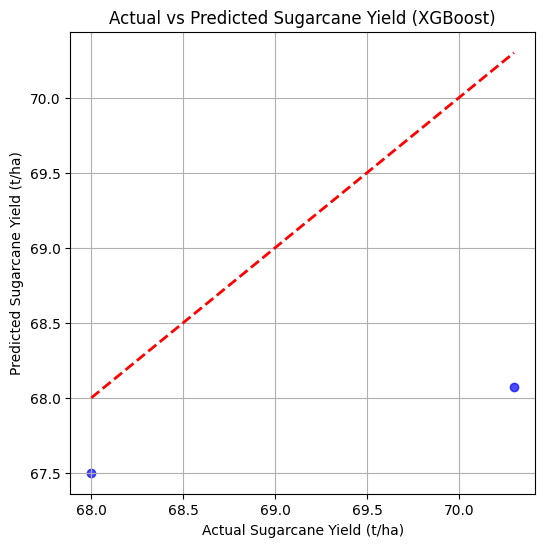

NDVI: 0.4035
precipitation: 0.5965
temperature_2m: 0.0000


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# -------------------------------
# Select sugarcane as the target crop
# -------------------------------
target_crop = 'sugarcane_yield_t_ha'

# -------------------------------
# Prepare data
# -------------------------------
X = final_df[['NDVI', 'precipitation', 'temperature_2m']]
y = final_df[target_crop]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# =======================================
# 🌲 1) RANDOM FOREST MODEL
# =======================================
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=6,
    random_state=42
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("🌲 Random Forest Results:")
print("R² Score:", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("----------------------------------")

# =======================================
# 🚀 2) XGBOOST MODEL
# =======================================
xgb_model = xgb.XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("🚀 XGBoost Results:")
print("R² Score:", r2_score(y_test, y_pred_xgb))
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))

# =======================================
# 📊 Visualize Actual vs Predicted (XGB)
# =======================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_xgb, color='blue', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', linewidth=2)
plt.xlabel('Actual Sugarcane Yield (t/ha)')
plt.ylabel('Predicted Sugarcane Yield (t/ha)')
plt.title('Actual vs Predicted Sugarcane Yield (XGBoost)')
plt.grid(True)
plt.show()

# =======================================
# ⭐ Feature Importance (XGBoost)
# =======================================
importance = xgb_model.feature_importances_
for feature, score in zip(X.columns, importance):
    print(f"{feature}: {score:.4f}")


In [9]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import numpy as np

X = final_df[['NDVI', 'precipitation', 'temperature_2m']]
y = final_df['sugarcane_yield_t_ha']

loo = LeaveOneOut()

y_true = []
y_pred = []

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = xgb.XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=1.0,
        colsample_bytree=1.0,
        objective='reg:squarederror'
    )

    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    y_true.append(y_test.values[0])
    y_pred.append(pred[0])

print("R² Score:", r2_score(y_true, y_pred))
print("MAE:", mean_absolute_error(y_true, y_pred))


R² Score: -0.7774147090974752
MAE: 1.119158020019532
